<a href="https://colab.research.google.com/github/NeevSabhani/Data-Science/blob/main/Unit3/NeevSabhU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install "preliz[full,notebook]"
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

#**Unit 3 Project: Average Hourly Energy Consumption in the Northeastern United States**




##**Context**

What is the average hourly energy consumption in the northeastern United States, and why does it matter? Understanding this question is essential for energy providers, consumers, and policymakers alike. For companies like American Electric Power (AEP), knowing the average consumption patterns helps optimize power generation, reduce costs, and manage resources effectively. For consumers and decision-makers, insights into hourly energy usage enable better planning for energy efficiency, peak load reduction, and sustainable practices. Analyzing these patterns allows us to identify high-demand periods, anticipate future needs, and support initiatives for a greener, more reliable energy system.

The follwing uploads a CSV file of our data that we can use in our model:

In [4]:

AEP_csv = '/content/AEP_hourly.csv'

AEP = pd.read_csv(AEP_csv)


recieving_data = AEP[['AEP_MW']]
recieving_data

,AEP_MW
0,13478.0
1,12865.0
2,12577.0
3,12517.0
4,12670.0
...,...
121268,21089.0
121269,20999.0
121270,20820.0
121271,20415.0


Data is from [Kaggle](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

##**Histogram**

To being the construction of our model, we first start out with a historgram of our Data.

(array([ 3602., 15690., 24621., 30086., 22238., 14188.,  7396.,  2709.,
          673.,    70.]),
 array([ 9581. , 11192.4, 12803.8, 14415.2, 16026.6, 17638. , 19249.4,
        20860.8, 22472.2, 24083.6, 25695. ]),
 <BarContainer object of 10 artists>)

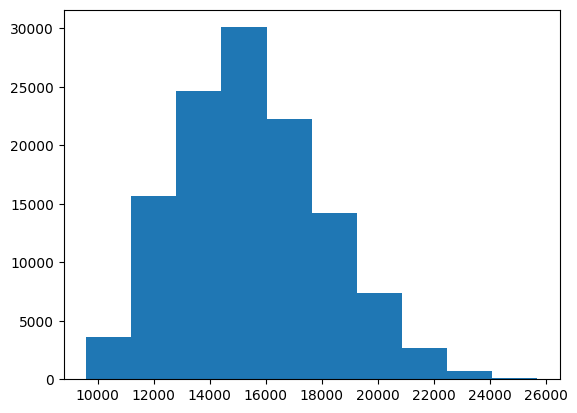

In [5]:
plt.hist(recieving_data)

###**Observed Trend**

Looking at our histogram which so generously represents our data visually, we can see that the data seems to be skewed to the right, indicating that most hourly consumption values are towards the lower end of our data range (11k - 18k) with few high values extending the distribution to the right (most likely because of the few outliers in the very northern most state during the winter time consuming high MW). Basically, this shows that while typical energy consumption is moderate, there are some spikes to much higher levels.


In [6]:
recieving_data.skew()

,0
AEP_MW,0.378998


This supports our conclusion by confirming that there is a positive skew.

##**Coming Up with Priors!**

When constructing our model, we needed to set initial assumptions for the mean (μ) and standard deviation (σ) of the energy consumption data.

Mean (μ): We chose a normal distribution for the mean energy consumption with a central value (μ) of 16,000 MW and a standard deviation (σ) of 2,000 MW. This decision is based on the observation that most of the hourly energy consumption values in our dataset cluster around this range. Setting the mean at 16,000 MW reflects our belief that the average energy usage is likely to be close to this value. The choice of a standard deviation of 2,000 MW allows the model to account for a moderate range of variability in the mean, capturing potential shifts in energy consumption that might occur due to seasonal changes, demand surges, or other influencing factors.

Standard Deviation (σ): For the standard deviation, we used a value of 2,000 MW. This choice reflects the expected variability in hourly energy consumption, capturing both minor fluctuations in typical daily usage and more significant deviations that might occur due to sudden changes in demand. By using a half-normal distribution for σ, we ensure that the standard deviation remains positive, which aligns with our expectation that consumption levels can vary but will not be negative.

Now using those priors we can make our first iteration of our model.

##**Model**



###**First Version**
For this first verion of my model, I will be using the two means that I have set above and I will be using a Normal likelihood.

In [7]:
#N for normal
with pm.Model() as model_AEP:
    # I have no idea where the mean should be, but its reasonable to assume
    # its between our lowest and highest values recorded
    μ = pm.Normal('μ', mu = 16000, sigma = 2000)

    #this one is new, but its exactly what it sounds like: half of a normal dist
    σ = pm.HalfNormal('σ', sigma=2000)

    #our fancy new likelihood, with two priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=recieving_data)
    sampledData = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

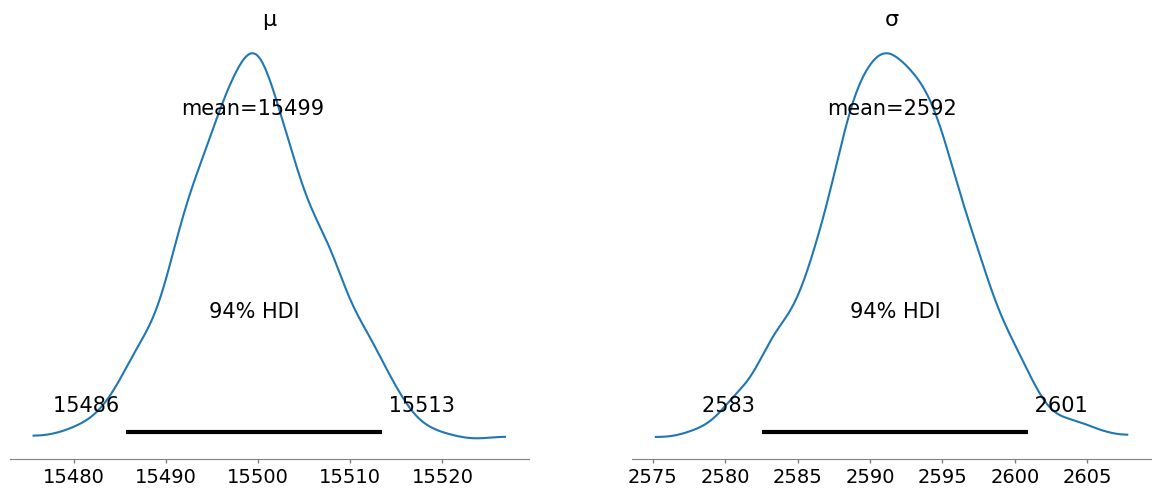

In [8]:
az.plot_posterior(sampledData)

Output()

<Axes: xlabel='Y'>

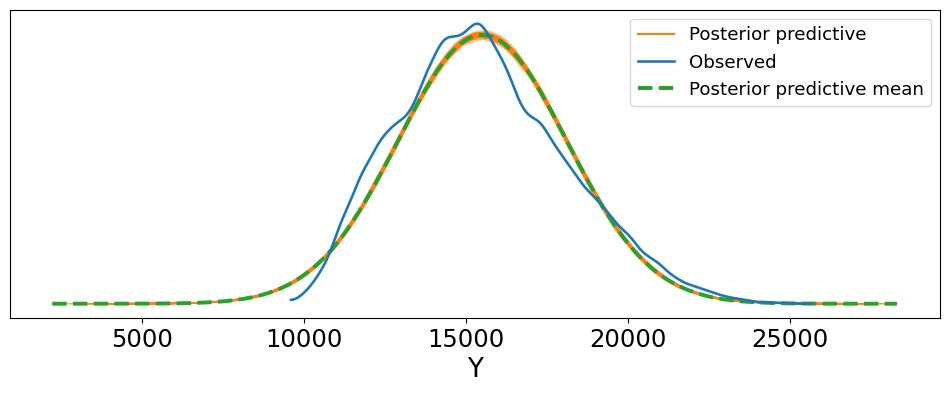

In [9]:
pm.sample_posterior_predictive(sampledData, model=model_AEP, extend_inferencedata=True)

az.plot_ppc(sampledData, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])


In this first version of my model, we can see that there is no skew in my posterior predictive even though there is skew in my data, so for my next model I will try using a Skewnormal Likelihood.

###**Version 2**



In [10]:
#N for normal
with pm.Model() as model_AEP2:
    # I have no idea where the mean should be, but its reasonable to assume
    # its between our lowest and highest values recorded
    μ = pm.Normal('μ', mu = 16000, sigma = 2000)

    #this one is new, but its exactly what it sounds like: half of a normal dist
    σ = pm.HalfNormal('σ', sigma=2000)

    #our fancy new likelihood, with two priors
    Y = pm.SkewNormal('Y', mu = μ, sigma = σ, observed=recieving_data)
    sampledData2 = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

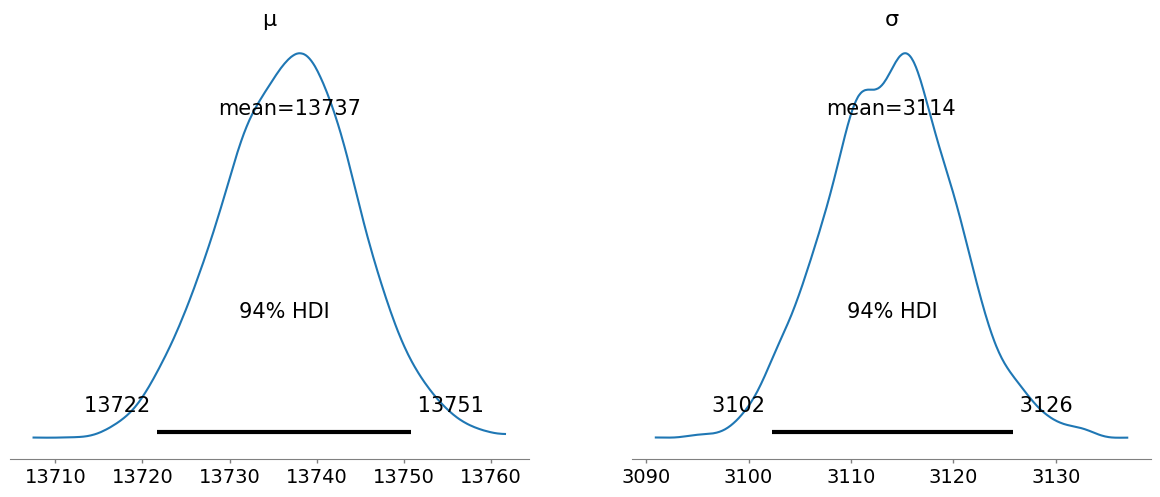

In [11]:
az.plot_posterior(sampledData2)

Output()

<Axes: xlabel='Y'>

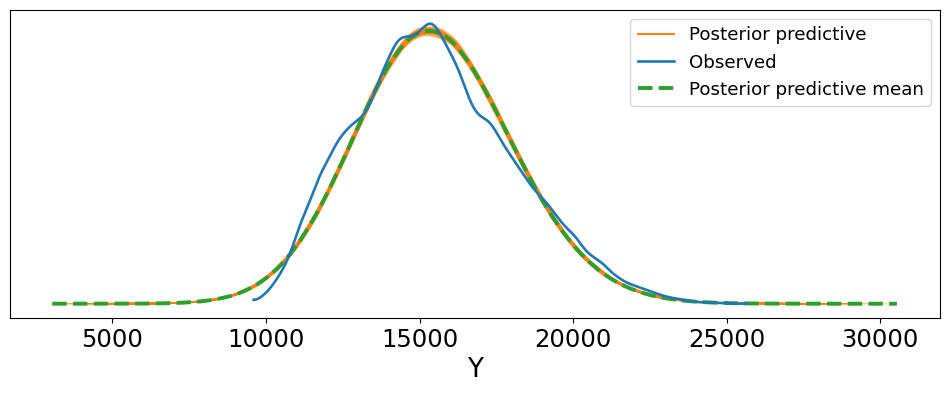

In [12]:
pm.sample_posterior_predictive(sampledData2, model=model_AEP2, extend_inferencedata=True)

az.plot_ppc(sampledData2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])

We can see that our model is much better now with our posterior predicted aligning with our obsereved data much better than our previous model.

##**Conclusion**

There we have it, our model's posterior predictive aligns well with the obsereved. So, why is our model even good? Well, lets look at the moments and compare them of the obsereved to our posterior predictive:


*   Mean: The posterior predictive distribution closely aligns with the mean of the observed data, indicating that the model accurately captures the central tendency of the hourly energy consumption. This agreement suggests that the chosen priors for the mean were appropriate, allowing the model to predict the typical energy consumption values reliably.
*   Skewness: The observed and predicted distributions both exhibit a shape that is nearly symmetric, with a slight right skew. This slight skew is consistent with the real-world data patterns, where occasional high consumption values cause a tail to extend to the right. The model's ability to replicate this skew indicates that it successfully captures the asymmetry present in the data, which is crucial for predicting periods of higher-than-average energy demand.
*Kurtosis: The kurtosis of both the observed data and the posterior predictive distribution appears to be similar, suggesting that the model accounts for the "tailedness" or the frequency of extreme values effectively. This alignment means the model can handle not only the typical energy consumption values but also the more extreme spikes in demand without overfitting to these outliers.
*Variance: The variance in the posterior predictive distribution is well-matched to the variance observed in the actual data. This similarity in spread indicates that the model accurately represents the degree of variability in energy consumption, reflecting both the day-to-day fluctuations and the larger shifts that can occur in response to external factors like weather changes or peak usage times.

The close match between the observed data and the posterior predictive checks demonstrates that the model successfully captures the overall distribution, central tendency, spread, and variability of the energy consumption data.This performance suggests that the priors and likelihood used in the model were well-chosen, providing a balanced and flexible framework for understanding hourly energy consumption in the northeastern United States.





Now, does our model reflect realty? Looking at our model, it is able to reproduce our data set well, but this data set takes into account years and years of data (I think from 2004). Over the years, changes such as climate change and new innovations have drastically changed the average hourly energy consumption for houses in the northeastern US. So while the model is able to reflect the data over the years, it probably will not be able to predict the averge energy consumption currently.